# Construcció d'un Classificador de Sentiments en Ressenyes de Pel·lícules amb Scikit-Learn a Python

Per a aquest projecte, farem servir un conjunt de dades de l'IMDB amb 50.000 ressenyes de pel·lícules disponible a Kaggle. Aquest conjunt de dades consta de dues columnes (resenya i sentiment) que ens ajudaran a identificar si una resenya és positiva o negativa.
La base de dades està disponible a 

Altres bases de dades:
https://www.kaggle.com/code/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews


In [147]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV


In [3]:
df = pd.read_csv('kaggle_movies_db.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


A continuació, explorem les dades del dataset

In [4]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [6]:
df.shape

(50000, 2)

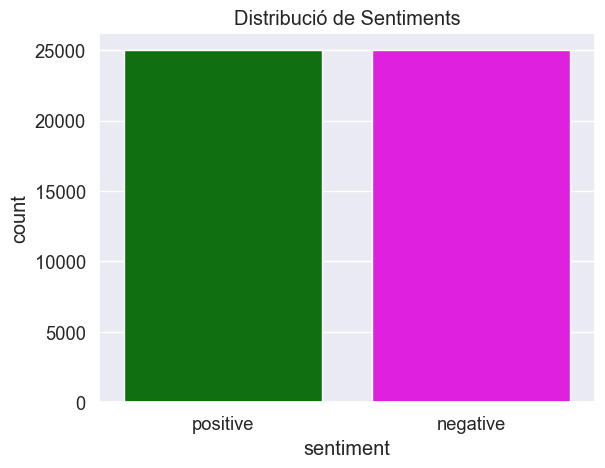

In [154]:
sns.countplot(x='sentiment', data=df, palette=['green', 'magenta'])
plt.title('Distribució de Sentiments')
plt.show()

Aquest conjunt de dades conté 50.000 files; no obstant això, per entrenar el nostre model de manera més ràpida en els passos seguents, agafarem una mostra més petita de 10.000 files. Aquesta petita mostra inclourà 9.000 ressenyes positives i 1.000 negatives per desequilibrar les dades.

Amb aquest desequilibri entre les dues classes (positiva i negativa), es crea una situació de undersampling i oversampling, que es seguirà per construir in model més robust:

<strong>Motius per explorar Undersampling:</strong>

Rapidesa d'entrenament: Amb una majoria de ressenyes positives, entrenar el model amb un subconjunt més petit (submostreig) de ressenyes positives pot accelerar el procés sense perdre la informació essencial de la classe majoritària.

Evitar la dominància: Amb tantes ressenyes positives, el model podria centrar-se massa en aquesta classe i ignorar la classe minoritària, afectant la seva habilitat per predir ressenyes negatives amb precisió.

<strong>Motius per explorar Oversampling:</strong>

Millora de la capacitat predictiva: Donada la petita quantitat de ressenyes negatives, fer un sobremostreig d'aquesta classe pot millorar la capacitat del model per reconèixer i aprendre patrons específics d'aquesta classe.

Reducció del desequilibri: L'oversampling aborda el desequilibri inherent, assegurant que el model no estigui sesgat cap a la classe majoritària i pugui fer prediccions més equitatives per ambdues classes.

En aquest treball es farà servir Undersampling

In [14]:
df_positive = df[df['sentiment']=='positive'][:9000]
df_negative = df[df['sentiment']=='negative'][:1000]

Fem una comprovació ràpida al dataframe per veure si s'han dividit correctament.

In [148]:
pd.options.display.max_colwidth = 270
df_positive

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which ...",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen ...",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected ...",positive
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encou...",positive
5,"Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it's not preachy or boring. It just never gets old, despite my having seen it some 15 or more times in the last 25 years. Paul Lukas' performance brings tear...",positive
...,...,...
18187,"The Sea Is Watching has been made from an original Akira Kurosawa script, and it is indeed a lush and warm film. Watching it will be a pleasure !<br /><br />Kei Kumai as director is certainly no equal to the old but everlasting master (particularly the mass scenes i...",positive
18188,"I used to watch this show when I was a little girl. Although I don't remember much about it, I must say that it was a pretty good show. Also, I don't think I've seen every episode. However, if you ask me, it was still a good show. I vaguely remember the theme song. ...",positive
18189,"John Leguizamo's one man show is both funnier and more involving than most movies you'll see. A number of devices, such as slide projectors, are used to enhance the story, but this is essentially good old-fashioned performance art. In particular, check out his hilar...",positive
18192,"in a not so conventional sense of the word.<br /><br />This movie was one of my favorites as a young child, and I just recently remembered it, and thought to look it up. While many of the details are no longer clear in my mind, the overall feeling that the movie gav...",positive


In [150]:
df_negative

,review,sentiment
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, fi...",negative
7,"This show was an amazing, fresh & innovative idea in the 70's when it first aired. The first 7 or 8 years were brilliant, but things dropped off after that. By 1990, the show was not really funny anymore, and it's continued its decline further to the complete waste ...",negative
8,"Encouraged by the positive comments about this film on here I was looking forward to watching this film. Bad mistake. I've seen 950+ films and this is truly one of the worst of them - it's awful in almost every way: editing, pacing, storyline, 'acting,' soundtrack (...",negative
10,Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.<br /><br />At first it was very odd and pretty funny but as the movie progressed I didn't find the jokes or oddness funny anymore.<b...,negative
11,I saw this movie when I was about 12 when it came out. I recall the scariest scene was the big bird eating men dangling helplessly from parachutes right out of the air. The horror. The horror.<br /><br />As a young kid going to these cheesy B films on Saturday after...,negative
...,...,...
2000,"Stranded in Space (1972) MST3K version - a very not good TV movie pilot, for a never to be made series, in which an astronaut finds himself trapped on Earth's evil twin. Having a planet of identical size and mass orbiting in the same plane as the earth, but on the o...",negative
2005,"I happened to catch this supposed ""horror"" flick late one Friday night, I wish I'd gone to bed! Tell me.. Is a 3 ft tall raincoat-clad twerp on a gurly bike supposed to convey some sort of fear? Not here, yet Mi-low is still able to beat the crap out of the janitor ...",negative
2007,"waste of 1h45 this nasty little film is one to avoid, its like a cheap badly plotted cross between saw and a few other recent films about kidnap, why the writer wrote this is obvious..he has no soul and did it to try and me some money. The twists were obvious, when ...",negative
2010,"Warning: This could spoil your movie. Watch it, see if you agree.<br /><br /> To think that we as humans can not learn from the past. The futuristic society portrayed glamorized what Hitler believed, obliterate a race of people (in this case men) for the benefit of ...",negative


Ara, concatenem els dataframes amb el nou mostreig

In [15]:
df_review_imb = pd.concat([df_positive, df_negative])

In [151]:
df_review_imb

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which ...",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen ...",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected ...",positive
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encou...",positive
5,"Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it's not preachy or boring. It just never gets old, despite my having seen it some 15 or more times in the last 25 years. Paul Lukas' performance brings tear...",positive
...,...,...
2000,"Stranded in Space (1972) MST3K version - a very not good TV movie pilot, for a never to be made series, in which an astronaut finds himself trapped on Earth's evil twin. Having a planet of identical size and mass orbiting in the same plane as the earth, but on the o...",negative
2005,"I happened to catch this supposed ""horror"" flick late one Friday night, I wish I'd gone to bed! Tell me.. Is a 3 ft tall raincoat-clad twerp on a gurly bike supposed to convey some sort of fear? Not here, yet Mi-low is still able to beat the crap out of the janitor ...",negative
2007,"waste of 1h45 this nasty little film is one to avoid, its like a cheap badly plotted cross between saw and a few other recent films about kidnap, why the writer wrote this is obvious..he has no soul and did it to try and me some money. The twists were obvious, when ...",negative
2010,"Warning: This could spoil your movie. Watch it, see if you agree.<br /><br /> To think that we as humans can not learn from the past. The futuristic society portrayed glamorized what Hitler believed, obliterate a race of people (in this case men) for the benefit of ...",negative


Visualitzem el nou dataset en un gràfic de barres

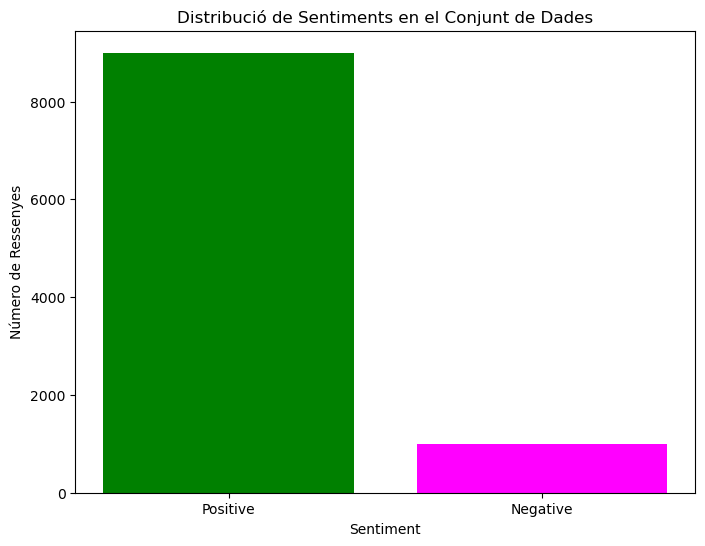

In [22]:
# Comptatge del nombre de ressenyes per classe
positive_count = df_positive.shape[0]
negative_count = df_negative.shape[0]

# Creació del gràfic de barres
plt.figure(figsize=(8, 6))
plt.bar(['Positive', 'Negative'], [positive_count, negative_count], color=['green', 'magenta'])

plt.xlabel('Sentiment')
plt.ylabel('Número de Ressenyes')
plt.title('Distribució de Sentiments en el Conjunt de Dades')

plt.show()

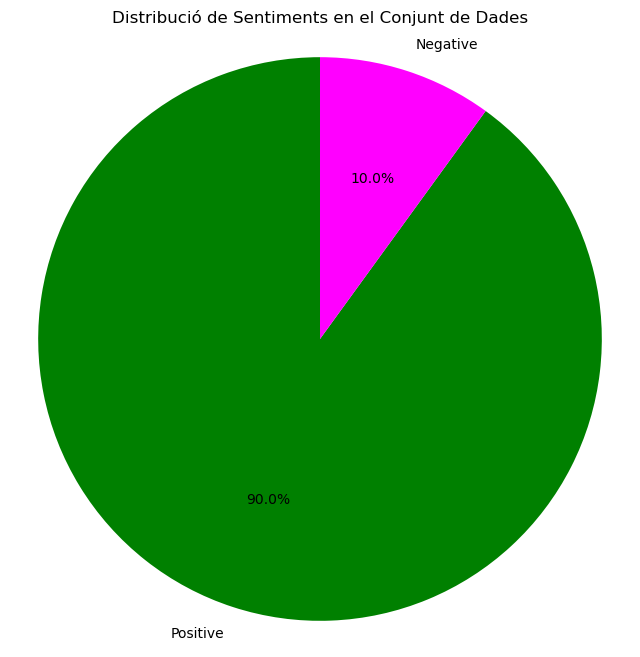

In [23]:
total_count = positive_count + negative_count
positive_percentage = (positive_count / total_count) * 100
negative_percentage = (negative_count / total_count) * 100

# Crea una figura de gràfic de sectors
plt.figure(figsize=(8, 8))

# Dibuixa el gràfic de sectors amb percentatges i comptes
labels = ['Positive', 'Negative']
sizes = [positive_count, negative_count]
percentages = [positive_percentage, negative_percentage]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['green', 'magenta'])

# Afegir etiquetes i títol
plt.axis('equal')  # Assegura que el gràfic de sectors sigui circular
plt.title('Distribució de Sentiments en el Conjunt de Dades')

# Mostra el gràfic
plt.show()

## Desbalanceig de dades

Per reequilibrar les nostres dades, fem servir la biblioteca imbalanced-learn (imblearn). Per al nostre projecte, farem servir la tècnica de undersampling RandomUnderSampler.

In [33]:
# desbalanceado
df_review_des = pd.concat([df_positive, df_negative])
df_review_des.value_counts('sentiment')

rus = RandomUnderSampler()
df_review_bal, df_review_bal['sentiment'] = rus.fit_resample(df_review_des[['review']], df_review_des['sentiment'])

df_review_bal.value_counts(['sentiment'])

sentiment
negative     1000
positive     1000
dtype: int64

Per reequilibrar les dades hem fet servir la tècnica de mostreig aleatori (RandomUnderSampler) per reduir el nombre de mostres de la classe majoritària (en aquest cas, la classe "positive") per igualar-lo al nombre de mostres de la classe minoritària (la classe "negative"). Després d'aplicar l'undersampling, s'obté un nou conjunt de dades (df_review_bal) amb 1000 mostres de cada classe.

El resultat indica que s'ha aconseguit un balanç perfecte (1000 registres en concret per cada classe) entre les dues classes després de l'aplicació de l'undersampling.

## Train-Test

Ara anem a dividir les nostres dades en dos congunts: un conjunt d'entrenament i un conjunt de proves. El conjunt d'entrenament s'utilitzarà per ajustar el model, mentres que el conjunt de proves es farà servir per proporcionar una avaluació imparcial d'un model final ajustat al conjunt d'entrenament.

Per dur a terme aquesta divisió, farem servir la funció <strong>train_test_split</strong> de la llibreria sklearn. En aquest cas, establim que el 33% de les dades es destinaran al conjunt de proves. Això significa que el 67% restant es farà servir com a conjunt d'entrenament.

La divisió de les dades en conjunts d'entrenament i proves ha de ser representatiu del conjunt de dades original per obtenir una avaluació precisa del model. A més, la divisió aleatòria de les dades ajuda a evitar l'overfitting del model als patrons específics del conjunt d'entrenament.

In [35]:
train, test = train_test_split(df_review_bal, test_size=0.33, random_state=42)

train_x, train_y = train['review'], train['sentiment']
test_x, test_y = test['review'], test['sentiment']

El conjunt de dades s'ha dividit en un conjunt d'entrenament i un conjunt de proves. Explico les variables resultants d'aquesta divisió:

train_x: Variables independents (review) que s'utilitzaran per entrenar el model. Com s'ha especificat test_size = 0.33, el 67% de les observacions del conjunt de dades es faran servir per ajustar el model.

train_y: Variables dependents (sentiment) o etiqueta objectiu que ha de ser predita per aquest model.

test_x: El 33% restant de les variables independents que es faran servir per fer prediccions per provar l'exactitud del model.

test_y: Les etiquetes de les categories que es faran servir per provar l'exactitud entre les categories reals i les categories predites.

Aquesta divisió serveix bàsicament per avaluar el rendiment del model en dades noves i no vistes durant l'entrenament. Per tant, el conjunt d'entrenament s'utilitza per ajustar el model, mentre que el conjunt de proves es fa servir per avaluar la seva precisió en dades noves.

Per visualitzar el resultat, imprimim les variables:

In [39]:
print("Distribució de Sentiments - Conjunt d'Entrenament:")
print(train_sentiment_counts)

print("\nDistribució de Sentiments - Conjunt de Proves:")
print(test_sentiment_counts)

Distribució de Sentiments - Conjunt d'Entrenament:
negative    675
positive    665
Name: sentiment, dtype: int64

Distribució de Sentiments - Conjunt de Proves:
positive    335
negative    325
Name: sentiment, dtype: int64


També en podem visualitzar els diferents conjuns de dades en gràfiques, on veiem que la distribució és molt similar:

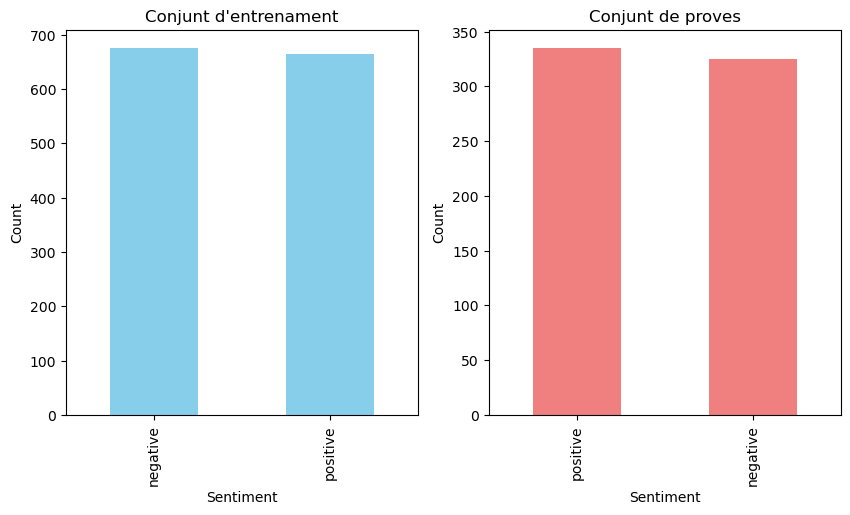

In [36]:
# Comptatge
train_sentiment_counts = train_y.value_counts()
test_sentiment_counts = test_y.value_counts()

# Gràfic
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
train_sentiment_counts.plot(kind='bar', ax=ax[0], color='skyblue')
ax[0].set_title('Conjunt d\'entrenament')
ax[0].set_xlabel('Sentiment')
ax[0].set_ylabel('Count')
test_sentiment_counts.plot(kind='bar', ax=ax[1], color='lightcoral')
ax[1].set_title('Conjunt de proves')
ax[1].set_xlabel('Sentiment')
ax[1].set_ylabel('Count')

plt.show()

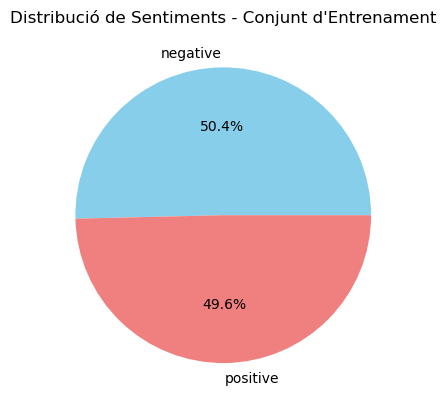

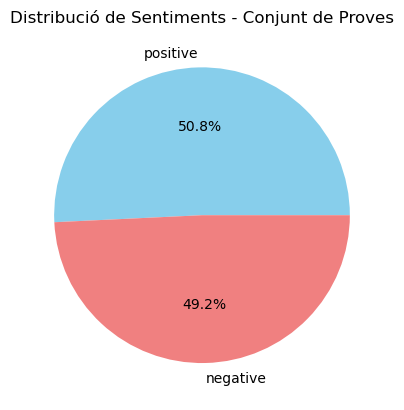

In [38]:
# Train
plt.pie(train_sentiment_counts, labels=train_sentiment_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Distribució de Sentiments - Conjunt d\'Entrenament')
plt.show()

# Test
plt.pie(test_sentiment_counts, labels=test_sentiment_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Distribució de Sentiments - Conjunt de Proves')
plt.show()


En ambdós casos, la distribució de sentiments és lleugerament més gran (<1) en els positius que en els negatius.

En la representació de text, els classificadors i algoritmes d'aprenentatge esperen vectors de característiques numèriques en comptes de documents de text en brut. Aquesta necessitat deriva de la naturalesa dels models que requereixen dades numèriques per funcionar adequadament.

Per aconseguir això en el nostre context de ressenyes de pel·lícules, hem d'aconseguir convertir el text de les ressenyes en vectors numèrics. Existeixen diverses tècniques per representar el text, com ara la codificació one-hot, la bossa de paraules (Bag of Words) i Word2Vec.

## Bag of Words(BOW)

Aquesta tècnica converteix els documents de text en vectors de longitud fixa comptant quants cops apareix cada paraula en el document (comparació amb el corpus).

Per aplicar la representació de la BOW, es poden utilitzar diverses tècniques com ara CountVectorizer i Term Frequency-Inverse Document Frequency (TF-IDF). El CountVectorizer simplement compta quants cops apareix cada paraula en un document, mentre que el TF-IDF ajusta aquestes freqüències en funció de la seva importància en tots els documents del conjunt de dades.

La representació de la BOW és útil quan es volen tenir en compte les freqüències de les paraules en els documents, però no la seva ordre. Això és particularment útil en tasques on la semàntica de les paraules és més rellevant que la seva estructura gramatical o la seva seqüència.

En aquesta tasca, optarem per utilitzar el CountVectorizer i el Term Frequency-Inverse Document Frequency (TF-IDF).

### Count Vectorizer

In [106]:
# Creem una instància de CountVectorizer
cv = CountVectorizer()

# Transformem les ressenyes d'entrenament en una matriu de comptadors
train_x_vector = cv.fit_transform(train_x)

# Transformem les ressenyes de prova en una matriu de comptadors
test_x_vector = cv.transform(test_x)

# Creem un DataFrame amb les matrius de comptadors per a les ressenyes d'entrenament i de prova
df_train_vector = pd.DataFrame(train_x_vector.toarray(), columns=cv.get_feature_names_out())
df_test_vector = pd.DataFrame(test_x_vector.toarray(), columns=cv.get_feature_names_out())

# Visualitzem el DataFrame amb les matrius de comptadors per a les ressenyes d'entrenament
print("DataFrame amb matriu de comptadors per a ressenyes d'entrenament:")
print(df_train_vector)

# Visualitzem el DataFrame amb les matrius de comptadors per a ressenyes de prova
print("\nDataFrame amb matriu de comptadors per a ressenyes de prova:")
print(df_test_vector)


DataFrame amb matriu de comptadors per a ressenyes d'entrenament:
      00  000  007  01pm  02  04  05  10  100  1000  ...  zorro  zuckers  \
0      0    0    0     0   0   0   0   0    0     0  ...      0        0   
1      0    0    0     0   0   0   0   0    0     0  ...      0        0   
2      0    0    0     0   0   0   0   2    0     0  ...      0        0   
3      0    0    0     0   0   0   0   1    0     0  ...      0        0   
4      0    0    0     0   0   0   0   0    0     0  ...      0        0   
...   ..  ...  ...   ...  ..  ..  ..  ..  ...   ...  ...    ...      ...   
1335   0    0    0     0   0   0   0   0    0     0  ...      0        0   
1336   0    0    0     0   0   0   0   0    1     0  ...      0        0   
1337   0    0    0     0   0   0   0   0    0     0  ...      0        0   
1338   0    0    0     0   0   0   0   0    0     0  ...      0        0   
1339   0    0    0     0   0   0   0   0    0     0  ...      0        0   

      zues  zuleta  z

Observem que tenim 20268 columnes (paraules úniques) en aquest dataframe. Algunes de les cel·les poden contenir el valor 0, ja que una paraula determinada pot no aparèixer en una ressenya específica. 

En la fase següent, aquestes matrius de comptadors es faran servir com a característiques d'entrada per als models de machine learning per predir el sentiment de les ressenyes de pel·lícules.

Ara mateix tenim 20268 paraules úniques (una per columna). Per refinar la llista de paraules, executarem el mateix codi però treient les 'stopwords' en anglès.

In [107]:
# Creem una instància de CountVectorizer amb eliminació de stopwords en anglès
cv = CountVectorizer(stop_words='english')

# Transformem les ressenyes d'entrenament en una matriu de comptadors
train_x_vector = cv.fit_transform(train_x)

# Transformem les ressenyes de prova en una matriu de comptadors
test_x_vector = cv.transform(test_x)

# Creem un DataFrame amb les matrius de comptadors per a les ressenyes d'entrenament i de prova
df_train_vector = pd.DataFrame(train_x_vector.toarray(), columns=cv.get_feature_names_out())
df_test_vector = pd.DataFrame(test_x_vector.toarray(), columns=cv.get_feature_names_out())

# Visualitzem el DataFrame amb les matrius de comptadors per a les ressenyes d'entrenament
print("DataFrame amb matriu de comptadors per a ressenyes d'entrenament:")
print(df_train_vector)

# Visualitzem el DataFrame amb les matrius de comptadors per a ressenyes de prova
print("\nDataFrame amb matriu de comptadors per a ressenyes de prova:")
print(df_test_vector)


DataFrame amb matriu de comptadors per a ressenyes d'entrenament:
      00  000  007  01pm  02  04  05  10  100  1000  ...  zorro  zuckers  \
0      0    0    0     0   0   0   0   0    0     0  ...      0        0   
1      0    0    0     0   0   0   0   0    0     0  ...      0        0   
2      0    0    0     0   0   0   0   2    0     0  ...      0        0   
3      0    0    0     0   0   0   0   1    0     0  ...      0        0   
4      0    0    0     0   0   0   0   0    0     0  ...      0        0   
...   ..  ...  ...   ...  ..  ..  ..  ..  ...   ...  ...    ...      ...   
1335   0    0    0     0   0   0   0   0    0     0  ...      0        0   
1336   0    0    0     0   0   0   0   0    1     0  ...      0        0   
1337   0    0    0     0   0   0   0   0    0     0  ...      0        0   
1338   0    0    0     0   0   0   0   0    0     0  ...      0        0   
1339   0    0    0     0   0   0   0   0    0     0  ...      0        0   

      zues  zuleta  z

El següent pas és aplicar la tècnica de representació de text coneguda com a "Term Frequency-Inverse Document Frequency" (TF-IDF) utilitzant l'objecte TfidfVectorizer de la llibreria scikit-learn. Aquest procés implica la transformació de les ressenyes de pel·lícules en vectors numèrics que representen la importància relativa de les paraules en el conjunt de dades.

Fonts:

https://towardsdatascience.com/text-vectorization-term-frequency-inverse-document-frequency-tfidf-5a3f9604da6d
    
https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/ch04.html

In [108]:
# Dividim el conjunt de dades en entrenament i prova
train, test = train_test_split(df_review_bal, test_size=0.33, random_state=42)

# Extraiem les ressenyes d'entrenament i prova
train_x, train_y = train['review'], train['sentiment']
test_x, test_y = test['review'], test['sentiment']

# Creem una instància de TfidfVectorizer amb eliminació de stopwords en anglès
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Transformem les ressenyes d'entrenament en una matriu TF-IDF
train_x_tfidf = tfidf_vectorizer.fit_transform(train_x)

# Transformem les ressenyes de prova en una matriu TF-IDF
test_x_tfidf = tfidf_vectorizer.transform(test_x)

# Creem un DataFrame amb les matrius TF-IDF per a les ressenyes d'entrenament i de prova
df_train_tfidf = pd.DataFrame(train_x_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
df_test_tfidf = pd.DataFrame(test_x_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Visualitzem el DataFrame amb les matrius TF-IDF per a les ressenyes d'entrenament
print("DataFrame amb matriu TF-IDF per a ressenyes d'entrenament:")
print(df_train_tfidf)

# Visualitzem el DataFrame amb les matrius TF-IDF per a les ressenyes de prova
print("\nDataFrame amb matriu TF-IDF per a ressenyes de prova:")
print(df_test_tfidf)


DataFrame amb matriu TF-IDF per a ressenyes d'entrenament:
       00  000  007  01pm   02   04   05        10       100  1000  ...  \
0     0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.000000  0.000000   0.0  ...   
1     0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.000000  0.000000   0.0  ...   
2     0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.151439  0.000000   0.0  ...   
3     0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.042773  0.000000   0.0  ...   
4     0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.000000  0.000000   0.0  ...   
...   ...  ...  ...   ...  ...  ...  ...       ...       ...   ...  ...   
1335  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.000000  0.000000   0.0  ...   
1336  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.000000  0.106276   0.0  ...   
1337  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.000000  0.000000   0.0  ...   
1338  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.000000  0.000000   0.0  ...   
1339  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.000000  0.000000   0.0  ...   

      zorro  zuckers  zues  zuleta  zzzz

Els resultats mostren la matriu TF-IDF per a les ressenyes d'entrenament i prova. La matriu mostra les ressenyes d'entrenament (1340 ressenyes) i les de prova (660 ressenyes). Cada fila representa una ressenya, i cada columna és una paraula única en tot el conjunt de dades.

Els valors de la matriu indiquen la importància relativa de cada paraula basada en la seva freqüència d'aparició i inversa documental.Aquests valors varien entre 0 (absència de la paraula) i valors més alts, reflectint la seva importància per a cada ressenya específica.

Sense stopwords, ara tenim un total de 19969 paraules úniques.

## Aprenentatge supervisat

El mètode triat per a aqueste projecte és l'aprenentatge supervisat. La diferència principal entre l'aprenentatge supervisat i l'aprenentatge no supervisat radica en el tipus de dades que s'utilitzen per entrenar els models.

En l'aprenentatge supervisat, els models s'entrenen amb conjunts de dades etiquetats, és a dir, les dades ja contenen les respostes desitjades. D'altra banda, en l'aprenentatge no supervisat, els models s'entrenen amb dades no etiquetades, és a dir, les dades no contenen les respostes desitjades i el model ha de descobrir patrons o estructures per si mateix.

L'aprenentatge supervisat ha estat triat per diverses raons. En primer lloc, en tenir etiquetes per a les dades, es pot avaluar de manera clara la precisió del model al predir les respostes desitjades. Això és fonamental en tasques com la classificació de ressenyes, on es vol predir la polaritat (positiva o negativa) d'una ressenya. En segon lloc, l'aprenentatge supervisat ofereix més control i direcció per al model, el que permet un rendiment més alineat amb les expectatives dels usuaris finals. Al final, aquest projecte disposa de dades etiquetades, la qual cosa fa que l'aprenentatge supervisat sigui la opció més adient per aconseguir els objectius de classificació de ressenyes. Les ressenyes són valors discrets, negatives/possitives.

Fonts:
https://www.ibm.com/blog/supervised-vs-unsupervised-learning/
https://www.v7labs.com/blog/supervised-vs-unsupervised-learning
moveworks.com/us/en/resources/blog/supervised-vs-unsupervised-learning-whats-the-difference

A continuació, farem benchmarking de quatre tipus d'aprenentatge supervisar i triarem el que millor s'ajusta al model.
<ol>
    <li>Support Vector Machines (SVM)</li>
    <li>Decision Tree</li>
    <li>Naive Bayes</li>
    <li>Logistic Regression</li>
</ol>

### 1. Support Vector Machines (SVM)

Per ajustar un model SVM, és necessari introduir les dades d'entrada (les ressenyes de text com a vectors numèrics) i les dades de sortida (el sentiment). En aquest projecte, l'ús de l'aprenentatge supervisat és preferible perquè disposem de dades etiquetades de sentiments associats a les ressenyes. Això permetrà entrenar el model per predir amb precisió el sentiment de les ressenyes de text.

In [112]:
# Creem una instància del classificador SVM amb el nucli lineal
svc = SVC(kernel='linear')

# Entrenem el model SVM utilitzant les dades d'entrenament
svc.fit(train_x_tfidf, train_y)

SVC(kernel='linear')

Ara comprovarem si el model encerta amb unes frase de mostra. De fet, triarem de fer petits canvis entre la frase 2 i la 3 per veure si el model discrimina entre matissos i per últim farem una oració adversativa per comprovar si encerta.

In [111]:
# Prediccions utilitzant el model SVM entrenat
prediction_1 = svc.predict(tfidf_vectorizer.transform(['A great film']))
prediction_2 = svc.predict(tfidf_vectorizer.transform(['A nice film but it could be better']))
prediction_3 = svc.predict(tfidf_vectorizer.transform(['A nice film']))
prediction_4 = svc.predict(tfidf_vectorizer.transform(['I was going to say something good, but I simply cannot because the movie is so bad.']))

# Mostrem les prediccions
print("Predicció per 'A great film':", prediction_1)
print("Predicció per 'A nice film but it could be better':", prediction_2)
print("Predicció per 'A nice film':", prediction_3)
print("Predicció per 'I was going to say something good, but I simply cannot because the film is so bad.':", prediction_4)

Predicció per 'A great film': ['positive']
Predicció per 'A nice film but it could be better': ['negative']
Predicció per 'A nice film': ['positive']
Predicció per 'I was going to say something good, but I simply cannot because the film is so bad.': ['negative']


Les conclusions del model són positives: fins ara, ha encertat tot.

### 2. Decision Tree

In [110]:
# Creem una instància del classificador d'arbres de decisió
dec_tree = DecisionTreeClassifier()

# Entrenem el model amb les dades d'entrenament
dec_tree.fit(train_x_vector, train_y)

# Fes la predicció amb el model per a noves dades
prediction_dec_tree = dec_tree.predict(test_x_vector)

Per visualitzar els resultats de l'arbre de decisió, emmagatzemarem els resultats en un dataframe.

In [113]:
df_predictions_dec_tree = pd.DataFrame({
    'Resenya': test_x,  # Les ressenyes originals
    'Sentiment Real': test_y,  # Els sentiments reals
    'Predicció': prediction_dec_tree  # Les prediccions del Decision Tree Classifier
})

df_predictions_dec_tree.head(10)

,Resenya,Sentiment Real,Predicció
1860,"Brokedown Palace is the story of two best friends, Alice and Darlene, who go on a spontaneous trip to Thailand and wind up in prison after being caught with planted drugs in their luggage. In this way, the movie had the potential to turn into a serious and moving fi...",positive,positive
353,Never saw the original movie in the series...I only hope it was a much better movie than this or the sequel made in the 1980's as if it is not how were these two terrible sequels even justified. This movie had a really good lead in when they were advertising it to b...,negative,negative
1333,"The essential message - one which Miller would have surely intended after seeing Vichy war crimes trials - is that hatred of somebody without rational basis is a waste of life. Meat Loaf's character, Fred, has known Lawrence for many years, and yet when the time com...",positive,negative
905,"At the beginning of the film, you might double-check the DVD cover and re-read the synopsis a couple of times, but no worries. It's NOT ""Memoirs of a Geisha"" that you purchased; just a movie with an intro that is much more classy and stylish than it has any right to...",negative,negative
1289,"With the badly injured Tony in an induced coma, two things happen: Tony imagines himself leading the life of a salesman attending a business convention, while his family and friends go through hell trying to cope with the possible loss of the big man. The dream sequ...",positive,positive
1273,Child 'Sexploitation' is one of the most serious issues facing our world today and I feared that any film on the topic would jump straight to scenes of an explicitly sexual nature in order to shock and disturb the audience. After having seen both 'Trade' and 'Holly'...,positive,negative
938,"For a really wonderful movie, you could also try seeing the movie about Saint Francis of Assisi - good for any audience. Best thing I liked about this movie was the Mexico landscape, & it gets the movie up to a 2. I was surprised that these actors didn't have terrib...",negative,negative
1731,"The mere presence of Sam Waterston as an Indian, is enough to put this movie in the must-see category. He is both beautiful and very subtle, with no lines whatsoever. He is tender with his kidnappee, and yet we can see he is among the proudest of all young Indian Me...",positive,positive
65,"I have now seen quite a few films by Pedro Almodóvar, but this would have to be the most disappointing so far. This film seemed to lack the zaniness that is usually everywhere in his films, and the story just never got me interested. Many Almodóvar regulars appear i...",negative,positive
1323,"When this was first aired on Masterpiece Theatre, it had a profound effect on me. It's beautifully filmed and acted. I immediately read the book by Mary Webb, and it remains one of my all time favorites. Janet McTeer is wonderful as Prue, and I fully expected her to...",positive,positive


En aquesta primera aproximació, podem veure com molts dels sentiments reals comparats amb els sentiments de l'arbre de decisió no coincideixen en algun cas.

### 3. Naive Bayes

In [114]:
# Creem i ajustem el model Naive Bayes amb les dades d'entrenament
gnb = GaussianNB()
gnb.fit(train_x_tfidf.toarray(), train_y)

# Fem prediccions amb les ressenyes de prova
prediccions_naive_bayes = gnb.predict(test_x_tfidf.toarray())

# Creem un DataFrame amb les prediccions
df_prediccions_naive_bayes = pd.DataFrame({
    'Resenya': test_x,  # Les ressenyes originals
    'Sentiment Real': test_y,  # Els sentiments reals
    'Predicció Naive Bayes': prediccions_naive_bayes  # Les prediccions del Naive Bayes
})

# Imprimim el DataFrame complet amb ressenyes, sentiments reals i prediccions
# pd.options.display.max_colwidth = 270

df_prediccions_naive_bayes.head(10)


,Resenya,Sentiment Real,Predicció Naive Bayes
1860,"Brokedown Palace is the story of two best friends, Alice and Darlene, who go on a spontaneous trip to Thailand and wind up in prison after being caught with planted drugs in their luggage. In this way, the movie had the potential to turn into a serious and moving fi...",positive,positive
353,Never saw the original movie in the series...I only hope it was a much better movie than this or the sequel made in the 1980's as if it is not how were these two terrible sequels even justified. This movie had a really good lead in when they were advertising it to b...,negative,positive
1333,"The essential message - one which Miller would have surely intended after seeing Vichy war crimes trials - is that hatred of somebody without rational basis is a waste of life. Meat Loaf's character, Fred, has known Lawrence for many years, and yet when the time com...",positive,positive
905,"At the beginning of the film, you might double-check the DVD cover and re-read the synopsis a couple of times, but no worries. It's NOT ""Memoirs of a Geisha"" that you purchased; just a movie with an intro that is much more classy and stylish than it has any right to...",negative,negative
1289,"With the badly injured Tony in an induced coma, two things happen: Tony imagines himself leading the life of a salesman attending a business convention, while his family and friends go through hell trying to cope with the possible loss of the big man. The dream sequ...",positive,negative
1273,Child 'Sexploitation' is one of the most serious issues facing our world today and I feared that any film on the topic would jump straight to scenes of an explicitly sexual nature in order to shock and disturb the audience. After having seen both 'Trade' and 'Holly'...,positive,positive
938,"For a really wonderful movie, you could also try seeing the movie about Saint Francis of Assisi - good for any audience. Best thing I liked about this movie was the Mexico landscape, & it gets the movie up to a 2. I was surprised that these actors didn't have terrib...",negative,negative
1731,"The mere presence of Sam Waterston as an Indian, is enough to put this movie in the must-see category. He is both beautiful and very subtle, with no lines whatsoever. He is tender with his kidnappee, and yet we can see he is among the proudest of all young Indian Me...",positive,positive
65,"I have now seen quite a few films by Pedro Almodóvar, but this would have to be the most disappointing so far. This film seemed to lack the zaniness that is usually everywhere in his films, and the story just never got me interested. Many Almodóvar regulars appear i...",negative,negative
1323,"When this was first aired on Masterpiece Theatre, it had a profound effect on me. It's beautifully filmed and acted. I immediately read the book by Mary Webb, and it remains one of my all time favorites. Janet McTeer is wonderful as Prue, and I fully expected her to...",positive,negative


En els resultats de les prediccions Naive Bayes comprovem que la coincidència amb el sentiment real és més acurada que en el cas anterior.

### 4. Logistic Regesssion

In [115]:
# Creem una instància de LogisticRegression
log_reg = LogisticRegression()

# Entrenem el model amb les dades d'entrenament
log_reg.fit(train_x_tfidf, train_y)

# Fem prediccions amb les dades de prova
predictions_log_reg = log_reg.predict(test_x_tfidf)

In [116]:
df_predictions_log_reg = pd.DataFrame({
    'Ressenya': test_x,  # Les ressenyes originals
    'Sentiment Real': test_y,  # Els sentiments reals
    'Predicció Logistic Regression': predictions_log_reg # Les prediccions del Logistic Regression
})

df_predictions_log_reg.head(10)


,Ressenya,Sentiment Real,Predicció Logistic Regression
1860,"Brokedown Palace is the story of two best friends, Alice and Darlene, who go on a spontaneous trip to Thailand and wind up in prison after being caught with planted drugs in their luggage. In this way, the movie had the potential to turn into a serious and moving fi...",positive,positive
353,Never saw the original movie in the series...I only hope it was a much better movie than this or the sequel made in the 1980's as if it is not how were these two terrible sequels even justified. This movie had a really good lead in when they were advertising it to b...,negative,negative
1333,"The essential message - one which Miller would have surely intended after seeing Vichy war crimes trials - is that hatred of somebody without rational basis is a waste of life. Meat Loaf's character, Fred, has known Lawrence for many years, and yet when the time com...",positive,positive
905,"At the beginning of the film, you might double-check the DVD cover and re-read the synopsis a couple of times, but no worries. It's NOT ""Memoirs of a Geisha"" that you purchased; just a movie with an intro that is much more classy and stylish than it has any right to...",negative,negative
1289,"With the badly injured Tony in an induced coma, two things happen: Tony imagines himself leading the life of a salesman attending a business convention, while his family and friends go through hell trying to cope with the possible loss of the big man. The dream sequ...",positive,positive
1273,Child 'Sexploitation' is one of the most serious issues facing our world today and I feared that any film on the topic would jump straight to scenes of an explicitly sexual nature in order to shock and disturb the audience. After having seen both 'Trade' and 'Holly'...,positive,positive
938,"For a really wonderful movie, you could also try seeing the movie about Saint Francis of Assisi - good for any audience. Best thing I liked about this movie was the Mexico landscape, & it gets the movie up to a 2. I was surprised that these actors didn't have terrib...",negative,negative
1731,"The mere presence of Sam Waterston as an Indian, is enough to put this movie in the must-see category. He is both beautiful and very subtle, with no lines whatsoever. He is tender with his kidnappee, and yet we can see he is among the proudest of all young Indian Me...",positive,negative
65,"I have now seen quite a few films by Pedro Almodóvar, but this would have to be the most disappointing so far. This film seemed to lack the zaniness that is usually everywhere in his films, and the story just never got me interested. Many Almodóvar regulars appear i...",negative,negative
1323,"When this was first aired on Masterpiece Theatre, it had a profound effect on me. It's beautifully filmed and acted. I immediately read the book by Mary Webb, and it remains one of my all time favorites. Janet McTeer is wonderful as Prue, and I fully expected her to...",positive,positive


Aquí trobem aparentment un bon rendiment del model de regressió logística a l'hora de predir el sentiment de les ressenyes

## Avaluació del model

In [117]:
tfidf = TfidfVectorizer(stop_words='english')
train_x_vector = tfidf.fit_transform(train_x)

test_x_vector = tfidf.transform(test_x)

In [127]:
# Avalua el rendiment del model SVM
svc_score = svc.score(test_x_tfidf, test_y)
print(f"Rendiment del model SVM: {round(svc_score, 2)}")

# Avalua el rendiment del model Decision Tree
dec_tree_score = dec_tree.score(test_x_tfidf, test_y)
print(f"Rendiment del model Decision Tree: {round(dec_tree_score, 2)}")

# Avalua el rendiment del model Naive Bayes
gnb_score = gnb.score(test_x_tfidf.toarray(), test_y)
print(f"Rendiment del model Naive Bayes: {round(gnb_score, 2)}")

# Avalua el rendiment del model Logistic Regression
log_reg_score = log_reg.score(test_x_tfidf, test_y)
print(f"Rendiment del model Logistic Regression: {log_reg_score}")


Rendiment del model SVM: 0.85
Rendiment del model Decision Tree: 0.51
Rendiment del model Naive Bayes: 0.63
Rendiment del model Logistic Regression: 0.85


En la elecció entre el Support Vector Classifier (SVC) i la Logistic Regression, hem observat que els resultats obtinguts per a ambdós models són molt similars. En aquest context, hem decidit optar per l'SVC.

El SVM és conegut per la seva eficàcia en la classificació de conjunts de dades no lineals. Encara que els resultats inicials no mostressin diferències significatives, la capacitat del SVM per trobar el millor límit de decisió entre les classes el fa un millor candidat en quant a tasques de classificació de text, on la separació entre les classes pot ser complexa.

https://robots.ox.ac.uk/~az/lectures/ml/lect2.pdf

Per avaluar el rendiment del model SVM, es faran servir les següents tècniques d'avaluació:
<ol>
<li>F1 Score: </li>Aquesta mètrica proporciona un equilibri entre la precisió i la sensibilitat del model. És particularment útil en tasques de classificació on hi ha un desequilibri entre les classes.
    
<li>Classification Report:</li> Aquest informe proporciona una visió detallada de diverses mètriques d'avaluació del model, com ara precisió, sensibilitat, F1-score i suport per a cada classe.
    
<li>Confusion Matrix:</li> Aquesta matriu ofereix una visió detallada de les prediccions del model, incloent els valors de vertader positiu, fals positiu, vertader negatiu i fals negatiu. Això és útil per entendre com el model classifica les mostres i identificar possibles errors de classificació.
</ol> 

### 1. F1 Score

L'F1 Score és una mesura de la mitjana ponderada de la Precisió (Precission) i la Sensibilitat (Recall). Mentres que l'exactitud es fa servir quan els Vertaders Positius i els Vertaders Negatius són més importants, l'F1-score es fa servir quan els Falsos Negatius i els Falsos Positius són crucials. A més, l'F1-score té en compte com estan distribuïdes les dades, de manera que és útil quan es treballa amb classes desbalancejades.

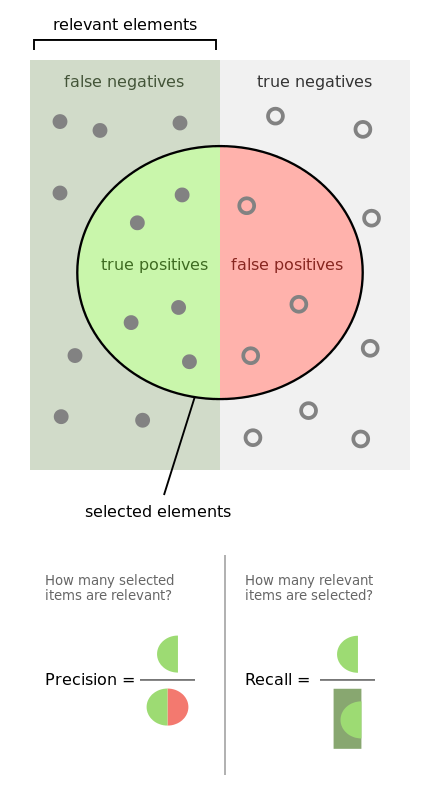

Font: https://stackoverflow.com/questions/14117997/what-does-recall-mean-in-machine-learning


L'F1-score es calcula amb la fórmula següent:

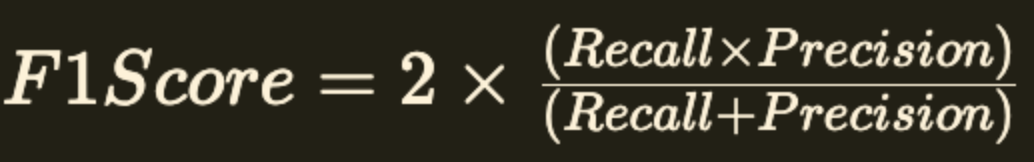

L'elecció de l'F1-score com a mesura d'avaluació és deguda a la seva capacitat per combinar la Precisió i la Sensibilitat en una sola mètrica, oferint una visió equilibrada del rendiment del model en tasques de classificació. A més, l'F1-score és particularment útil en tasques on les classes estan desbalancejades, ja que dóna igual pes a la Precisió i la Sensibilitat mitjançant la mitjana harmònica.

Fonts:

https://www.v7labs.com/blog/f1-score-guide

https://www.baeldung.com/cs/multi-class-f1-score


In [128]:
# F1 Score per a cada classe
svc_f1_scores = f1_score(test_y, svc.predict(test_x_vector),
                         labels=['positive', 'negative'],
                         average=None)

print("F1 Score per a cada classe amb SVC:")
print("Positive F1 Score:", svc_f1_scores[0])
print("Negative F1 Score:", svc_f1_scores[1])


F1 Score per a cada classe amb SVC:
Positive F1 Score: 0.8529411764705882
Negative F1 Score: 0.84375


En aquesta primera aproximació a l'avaluació del model mitjançant F1 Score, veiem que ambdós valors són propers a 1, lo qual indica que les prediccions són acurades.

### 2. Classification Report

En aquest punt, es procedirà a generar un informe de text que mostrarà les principals mètriques de classificació, incloent algunes que s'han calculat prèviament en aquest treball.

Aquest informe proporcionarà informació detallada sobre mètriques importants com ara Precisió, Sensibilitat, F1-Score i suport per a cada classe, oferint una visió completa del rendiment del model en la classificació de les ressenyes de text.

In [132]:
# Imprimeix el informe de classificació amb SVC
print("Informe de classificació amb SVC:")
print(classification_report(test_y, 
                            svc.predict(test_x_vector),
                            labels=['positive', 'negative']))


Informe de classificació amb SVC:
              precision    recall  f1-score   support

    positive       0.84      0.87      0.85       335
    negative       0.86      0.83      0.84       325

    accuracy                           0.85       660
   macro avg       0.85      0.85      0.85       660
weighted avg       0.85      0.85      0.85       660



La precisió indica la proporció de prediccions positives que són correctes, mentre que la sensibilitat mesura la capacitat del model per identificar correctament les mostres positives.

En aquest cas, observem que el model té una precisió (precision) del 84% per a la classe "positiva" i del 86% per a la classe "negativa". Això indica que la majoria de les prediccions positives i negatives són correctes.

D'altra banda, la sensibilitat (recall) del model és del 87% per a la classe "positiva" i del 83% per a la classe "negativa", la qual cosa suggereix que el model és bo a l'hora de trobar mostres positives i negatives en el conjunt de dades.

L'F1 Score, com ja s'ha vist en el prèviamen en aquest treball, ofereix uns resultats bons del 85 i 84% per a les classes positives i negatives respectivament.

Finalment, l'exactitud (accuracy) global del model és del 85%, la qual cosa indica la proporció de prediccions correctes en el conjunt de dades.

Fonts:

https://www.scikit-yb.org/en/latest/api/classifier/classification_report.html

### 3. Confusion Matrix

La matriu de confusió és una eina clau en l'avaluació de models de classificació, ja que ofereix una representació visual del rendiment de l'algorisme. Aquesta taula típicament té dues files i dues columnes que informen sobre el nombre de falsos positius, falsos negatius, vertaders positius i vertaders negatius. Aquesta informació és crucial per entendre com el model classifica les mostres i identificar possibles errors de classificació.

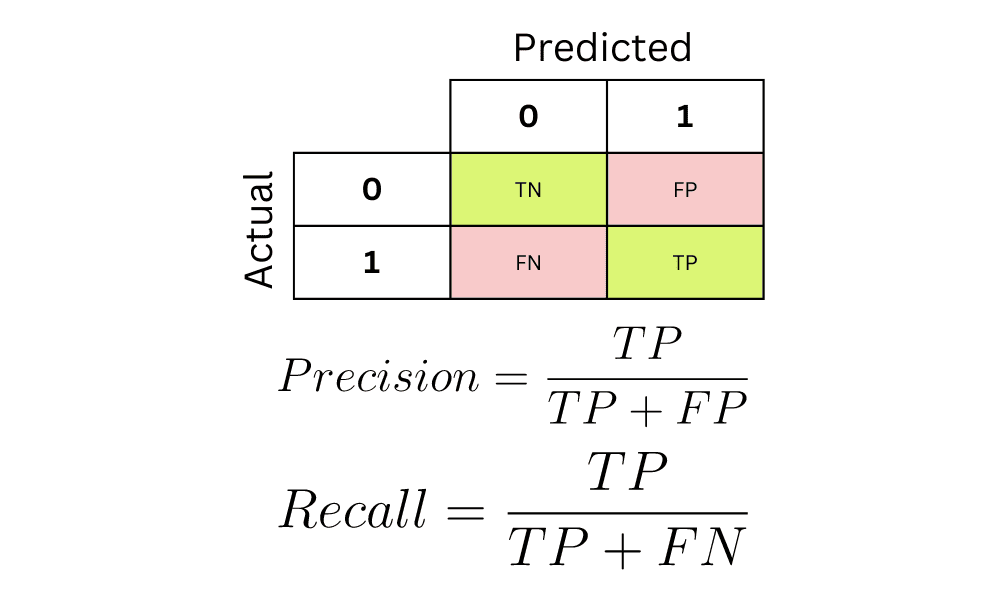

Font:

https://www.kdnuggets.com/2022/11/confusion-matrix-precision-recall-explained.html


Com es pot observar, un problema de classificació binària té només dues classes per classificar, preferiblement una classe positiva i una classe negativa. Ara analitzarem les mètriques de la Matriu de Confusió.

Vertader Positiu (TP): Es refereix al nombre de prediccions on el classificador prediu correctament la classe positiva com a positiva.

Vertader Negatiu (TN): Es refereix al nombre de prediccions on el classificador prediu correctament la classe negativa com a negativa.

Fals Positiu (FP): Es refereix al nombre de prediccions on el classificador prediu incorrectament la classe negativa com a positiva.

Fals Negatiu (FN): Es refereix al nombre de prediccions on el classificador prediu incorrectament la classe positiva com a negativa.


Fonts:
    
https://stackoverflow.com/questions/73308803/how-to-get-classification-report-from-the-confusion-matrix

https://www.projectpro.io/recipes/generate-classification-report-and-confusion-matrix-in-python

https://www.linkedin.com/advice/3/what-difference-between-confusion-matrix-classification-hsehf

In [133]:
# Calcula la matriu de confusió amb SVC
conf_mat_svc = confusion_matrix(test_y, svc.predict(test_x_vector), labels=['positive', 'negative'])

# Imprimeix la matriu de confusió per a SVC
print("Matriu de confusió amb SVC:")
print(conf_mat_svc)


Matriu de confusió amb SVC:
[[290  45]
 [ 55 270]]


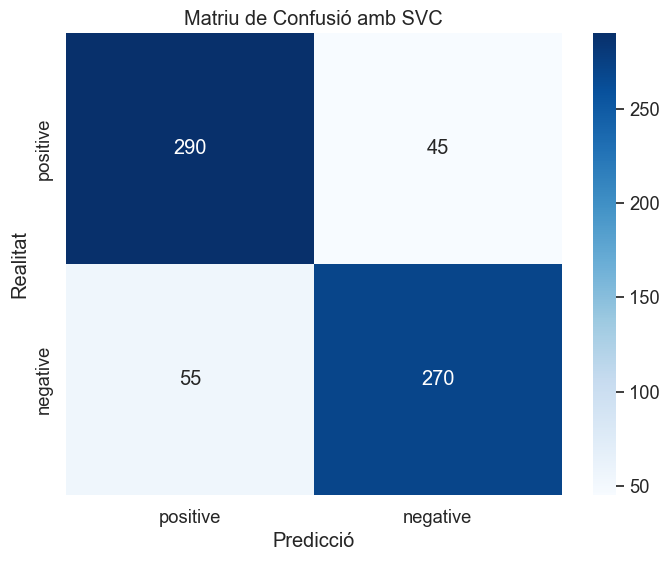

In [139]:
# Per veure els resultats en gràfic del paquet seaborn

# Calcula la matriu de confusió amb SVC
conf_mat_svc = confusion_matrix(test_y, svc.predict(test_x_vector), labels=['positive', 'negative'])

# Crea una figura i un eix per a la visualització amb Seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Ajusta la mida de la font per a millor llegibilitat

# Crea una visualització de mapa de calor amb Seaborn
sns.heatmap(conf_mat_svc, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['positive', 'negative'], yticklabels=['positive', 'negative'])

# Personalitza les etiquetes i el títol
plt.xlabel('Predicció')
plt.ylabel('Realitat')
plt.title('Matriu de Confusió amb SVC')

# Mostra la visualització
plt.show()


Els resultats poden ser interpretats de la següent manera:

Verdaders Positius (VP): 290 casos s'han classificat correctament com a "positive".

Falsos Positius (FP): 45 casos s'han classificat incorrectament com a "positive" quan en realitat eren "negative".

Falsos Negatius (FN): 55 casos s'han classificat incorrectament com a "negative" quan en realitat eren "positive".

Verdaders Negatius (VN): 270 casos s'han classificat correctament com a "negative".

En general, el rendiment del model és bo ja que presenta un nombre relativament baix de falsos positius i falsos negatius.

## Maximització del rendiment del model 

En aquest punt, és crucial maximitzar el rendiment del nostre model. Per aconseguir aquest objectiu, es farà servir la tècnica de GridSeachCV, la qual és una eina fonamental per ajustar els hiperparàmetres del model i trobar-ne els valors òptims. Aquest procés implica provar diverses combinacions de valors de hiperparàmetres i seleccionar aquells que ofereixin el millor rendiment per al nostre model.

La utilització d'aquesta tècnica ens permetrà millorar la capacitat predictiva del model i, per tant, augmentar la seva eficàcia en la classificació de les ressenyes de text.

Fonts:

https://towardsdatascience.com/gridsearchcv-for-beginners-db48a90114ee

https://www.mygreatlearning.com/blog/gridsearchcv/

In [144]:
import time

# Inicia el rellotge
start_time = time.time()

# Defineix els paràmetres amb les opcions que vols provar
parameters = {'C': [1, 4, 8, 16, 32], 'kernel': ['linear', 'rbf']}

# Crea una instància del model SVM
svc = SVC()

# Utilitza GridSearchCV per cercar els millors paràmetres a través de la validació creuada
svc_grid = GridSearchCV(svc, parameters, cv=5)

# Entrena el model amb les dades d'entrenament
svc_grid.fit(train_x_vector, train_y)

# Atura el rellotge
end_time = time.time()

# Calcula la diferència entre el temps d'inici i el temps final
execution_time = end_time - start_time

# Mostra els millors paràmetres trobats pel GridSearchCV
print("Millors paràmetres:", svc_grid.best_params_)

# Mostra el temps d'execució
print("Temps d'execució:", execution_time, "segons")


Millors paràmetres: {'C': 4, 'kernel': 'rbf'}
Temps d'execució: 35.94431018829346 segons


Els valors proporcionats per a 'C' i 'kernel' són 1, 4, 8, 16, 32 i 'linear', 'rbf' respectivament. Aquesta cerca exhaustiva de les combinacions de hiperparàmetres permetrà trobar aquells valors que ofereixin el millor rendiment per al model SVC en la classificació de les ressenyes de text.

En aquest cas, es consideren dos hiperparàmetres: 'C', que controla la penalització dels errors de classificació, i 'kernel', que especifica el tipus de funció de kernel a utilitzar en l'algoritme SVM.

In [143]:
import time

# Inicia el rellotge
start_time = time.time()

# Resta el temps actual al temps d'inici per obtenir el temps d'inici
svc_grid = GridSearchCV(svc, parameters, cv=5)
svc_grid.fit(train_x_vector, train_y)

# Atura el rellotge
end_time = time.time()

# Calcula la diferència entre el temps d'inici i el temps final
execution_time = end_time - start_time

# Mostra els paràmetres òptims
print("Paràmetres òptims:", svc_grid.best_params_)

# Mostra el temps d'execució
print("Temps d'execució:", execution_time, "segons")


Paràmetres òptims: {'C': 4, 'kernel': 'rbf'}
Temps d'execució: 35.86082625389099 segons


In [145]:
# Millors paràmetres obtinguts de la cerca de paràmetres
best_params = {'C': 4, 'kernel': 'rbf'}

# Crea una nova instància de SVC amb els millors paràmetres
optimized_svc = SVC(**best_params)

# Entrena el model amb les dades d'entrenament
optimized_svc.fit(train_x_vector, train_y)

# Fes prediccions amb les dades de prova
predictions = optimized_svc.predict(test_x_vector)

# Avalua el rendiment del model
accuracy = optimized_svc.score(test_x_vector, test_y)
print(f"Exactitud del model amb paràmetres optimitzats: {accuracy}")


Exactitud del model amb paràmetres optimitzats: 0.8560606060606061


La exactitud del model amb els paràmetres optimitzats és d'aproximadament 85.6%, la qual cosa significa que el 85.6% de les prediccions del model són correctes. Aquesta mètrica és una indicació positiva del rendiment del model, ja que està superant el 80%.

D'acord amb els resultats anteriors, hem utilitzat diverses tècniques com la matriu de confusió, els informes de classificació i l'índex F1 per analitzar de manera més completa el rendiment del model, i sempre obtenint uns resultats similars -en torn al 85%-.

# Conclusions generals 

En resum, els punts principals que ha abordat aquest treball d'anàlisi i classificació de ressenyes de pel·lícules es podem resumir en els següents:

### Desequilibri de les classes:

S'ha practicat al conjunt de dades un desequilibri significatiu entre les ressenyes positives i negatives, el que en ha permés l'aplicació de tècniques com l'undersampling per abordar aquesta qüestió.

### Importància de la representativitat en la divisió de les dades:

La divisió de les dades en conjunts d'entrenament i proves s'ha fet de manera representativa del conjunt de dades original per aconseguir una avaluació precisa del model. A més, la divisió aleatòria de les dades ha ajudat a evitar l'overfitting del model als patrons específics del conjunt d'entrenament.

### Aprenentatge supervisat:

En aquest cas, la classificació s'ha erigit com el tipus d'aprenentatge superisat necessari. S'han provat 4 tècniques. Support Vector Machines (SVM) i Logistic Regression han presentat els millors resultats, acurats en un 85%. Decision Tree i Naive Bayes han presentat precisions molt menors, al voltant de un 50%.

### Avaluació del model

F1 Score, Classification Report i Confusion Matrix, tècniques de SVC, han permés confirmar el bon rendiment del model (al voltant de un 85%), mentres que GridSearchCV ha optimitzat els hiperparàmetres del model, amb un rendiment molt similar (85%). 

### Reptes i millores:

Les principals dificultats trobades inclouen el desequilibri de les classes i l'aplicació de tècniques de mostreig per abordar-lo. Com a millores, es podria explorar l'ús de tècniques avançades de processament de llenguatge natural per millorar la classificació de les ressenyes i l'aplicació de mètodes de validació creuada per avaluacions més robustes.